In [5]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import grad, vmap

from coinem.kernels import MedianRBF, MeanRBF
from coinem.gradient_flow import stein_grad
from coinem.gradient_transforms import cocob

import optax as ox

# Gaussian mixture example:
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance
dist_a = MultivariateNormalFullCovariance(loc=[0.0, 0.0], covariance_matrix=[[1.0, 0.9], [0.9, 1.0]])
dist_b = MultivariateNormalFullCovariance(loc=[0.0, 0.0], covariance_matrix=[[1.0, -0.9], [-0.9, 1.0]])
log_prob = lambda x: jnp.logaddexp(dist_a.log_prob(x), dist_b.log_prob(x))

# Initialize particles:
num_particles = 100
key = jr.PRNGKey(123)
init = jr.normal(key, (num_particles, 2))

# Coin optimiser
optimizer = cocob()
opt_state = optimizer.init(init)

def step(carry: tuple, iter_num: int):

    # Get params and opt_state
    params, opt_state = carry

    # Compute SVGD gradient
    grads = stein_grad(particles=params, score=vmap(lambda p: grad(log_prob)(p)), kernel=MedianRBF())

    # Get parameter updates (and the optimser state update) according to the optimiser
    updates, opt_state = optimizer.update(-grads, opt_state, params)

    # Update the parameters
    new_params = ox.apply_updates(params, updates)
    
    # Update the carry
    carry = (new_params, opt_state)

    # Return the carry, and the new params
    return carry, None

# Run SVGD!
(params_final, opt_state_final), params_list = jax.lax.scan(step, (init, opt_state), jnp.arange(2000)) # Scan is a crazy fast for loop!

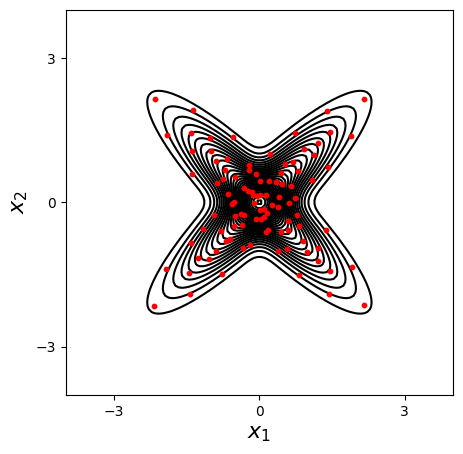

In [6]:
grid_res = 100

# Input locations at which to compute log-probabilities
x_plot = jnp.linspace(-3.5, 3.5, grid_res)
x_plot = jnp.stack(jnp.meshgrid(x_plot, x_plot), axis=-1)

# Compute log-probabilities
logp = log_prob(x_plot)

# Reshape to 3D and 2D arrays for plotting
x_plot = jnp.reshape(x_plot, (grid_res, grid_res, 2))
logp = logp.reshape((grid_res, grid_res))

# Plot density
plt.figure(figsize=(5, 5))
plt.contour(x_plot[:, :, 0],
             x_plot[:, :, 1],
             jnp.exp(logp),
             colors='black',
             levels=30
)

# Format plot
plt.xticks([-3, 0, 3])
plt.yticks([-3, 0, 3])
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.scatter(params_final[:, 0], params_final[:, 1], zorder=2, c='r', s=10)